# Lab 3 - Context

DeepLearning.AI - How Diffusion Models Work

[REF] https://learn.deeplearning.ai/courses/diffusion-models/

In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *

import warnings
warnings.filterwarnings('ignore')

# Context

In [2]:
# reset neural network
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [3]:
# load dataset and construct optimizer
dataset = CustomDataset("./dataset/L2_sprites_1788_16x16.npy", "./dataset/L2_sprite_labels_nc_1788_16x16.npy", transform, null_context=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


#### GPU is needed for Training.

In [4]:
# load in pretrain model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/L3_context_model_trained.pth", map_location=device))
nn_model.eval() 
print("Loaded in Context Model")

Loaded in Context Model


# Sampling with context

In [5]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = sample_ddpm_context(nn_model, 32, ctx)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [6]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

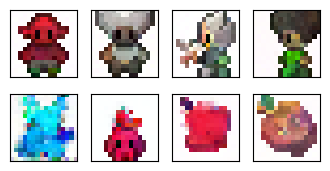

In [7]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],  
    [1,0,0,0,0],    
    [0,0,0,0,1],
    [0,0,0,0,1],    
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(nn_model, ctx.shape[0], ctx)
show_images(samples)

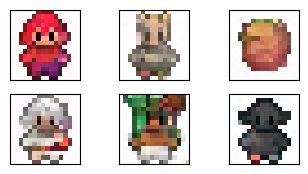

In [8]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(nn_model, ctx.shape[0], ctx)
show_images(samples)